In [159]:
import numpy as np
import random
from pymoo.core.problem import Problem
from pymoo.problems import get_problem
from pymoo.util.plotting import plot
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.visualization.scatter import Scatter

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize

In [160]:
class TSPProblem(Problem):
    def __init__(self, n_cities, seed=50):
        # Define the number of variables (cities) and objectives (time and distance)
        super().__init__(n_var=n_cities, n_obj=2, n_constr=0, xl=0, xu=1)
        
        # Initialize the random seed for reproducibility
        if seed is not None:
            np.random.seed(seed)
        
        # Generate random distances and times between cities
        self.distances = np.random.uniform(0, 100, size=(n_cities, n_cities))
        self.distances = (self.distances + self.distances.T) / 2
        self.times = np.random.uniform(0, 300, size=(n_cities, n_cities))
        random.seed(None)
        
        # Ensure the diagonal is zero (distance/time from a city to itself is zero)
        np.fill_diagonal(self.distances, 0)
        np.fill_diagonal(self.times, 0)

    def _evaluate(self, x, out, *args, **kwargs):
        # Calculate the total distance and time for each solution in x
        distances = []
        times = []
        
        for route in x:
            perm = np.argsort(route)
            total_distance = 0
            total_time = 0
            
            for i in range(len(perm) - 1):
                total_distance += self.distances[perm[i], perm[i+1]]
                total_time += self.times[perm[i], perm[i+1]]
            
            # Add distance and time from last city back to the first city
            total_distance += self.distances[perm[-1], perm[0]]
            total_time += self.times[perm[-1], perm[0]]
            
            distances.append(total_distance)
            times.append(total_time)
        
        out["F"] = np.column_stack([distances, times])

In [161]:
problem = TSPProblem(100)
print(np.shape(problem.distances))
print(np.shape(problem.times))

(100, 100)
(100, 100)


In [162]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.selection import Selection
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SimulatedBinaryCrossover
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.operators.selection.tournament import TournamentSelection
from pymoo.optimize import minimize
from pymoo.core.population import Population

In [163]:
# Definimos una selección personalizada
class CustomSelection(Selection):
    def _do(self, problem, pop, n_select, n_parents, **kwargs):
        """
        Selecciona padres basándose en una métrica personalizada.
        Por ejemplo, seleccionamos padres con base en crowding_distance o rank.
        """
        # Obtenemos los índices de las soluciones válidas
        selected = []
        for _ in range(n_select):
            # Selección basada en el rank y crowding_distance
            tournament = TournamentSelection(func_comp=self.custom_competition)
            indices = tournament._do(problem, pop, 1, n_parents, **kwargs)
            selected.append(indices)
        return Population.create(*selected)

    @staticmethod
    def custom_competition(ind_a, ind_b):
        """
        Compara dos individuos. Usa el rank primero y luego el crowding_distance.
        """
        if ind_a.F[0] < ind_b.F[0]:
            return ind_a
        elif ind_a.F[0] > ind_b.F[0]:
            return ind_b
        else:
            # Si tienen el mismo rank, desempatar por crowding_distance
            return ind_a if ind_a.crowding_distance > ind_b.crowding_distance else ind_b

In [164]:
# Configuramos el algoritmo con el operador de selección personalizado
algorithm = NSGA2(
    pop_size=100,
    sampling=FloatRandomSampling(),
    crossover=SimulatedBinaryCrossover(prob=0.9, eta=15),
    mutation=PolynomialMutation(eta=20),
    eliminate_duplicates=True,
    selection=CustomSelection(),
)

In [165]:
import numpy as np
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.core.sampling import Sampling

# Sampling personalizado para generar permutaciones aleatorias
class PermutationRandomSampling(Sampling):
    def _do(self, problem, n_samples, **kwargs):
        # Obtener el número de ciudades directamente del problema
        n_cities = problem.distances.shape[0]
        samples = np.array([np.random.permutation(n_cities) for _ in range(n_samples)])
        return samples

# Configuramos el algoritmo NSGA-II con el sampling personalizado
algorithm = NSGA2(
    pop_size=100,
    sampling=PermutationRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True,
)

# Inicializar el problema
problem = TSPProblem(n_cities=100)

# Ejecutar la optimización
res_custom = minimize(
    problem,
    algorithm,
    ("n_gen", 100),
    verbose=True,
)

# Mostrar los resultados
print("Población final:")
for f in res_custom.F:
    print(f)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |      4 |             - |             -
     2 |      200 |      4 |  0.000000E+00 |             f
     3 |      300 |      4 |  0.000000E+00 |             f
     4 |      400 |      4 |  0.000000E+00 |             f
     5 |      500 |      4 |  0.000000E+00 |             f
     6 |      600 |      3 |  0.2200445660 |         ideal
     7 |      700 |      4 |  0.1038589747 |             f
     8 |      800 |      6 |  0.1889471444 |         ideal
     9 |      900 |      8 |  0.0387835006 |             f
    10 |     1000 |     12 |  0.0143759965 |         ideal
    11 |     1100 |      3 |  0.2094870158 |         ideal
    12 |     1200 |      4 |  0.2158471601 |             f
    13 |     1300 |      3 |  0.2350623354 |         ideal
    14 |     1400 |      4 |  0.1558599555 |         ideal
    15 |     1500 |      5 |  0.0367891995 |             f
    16 |     1600 |      5 |  0.000000E+00 |            

In [166]:
from pymoo.core.algorithm import Algorithm
from pymoo.core.population import Population, Individual
import numpy as np
import random
import time

class CustomNSGAII(Algorithm):
    def __init__(self, pop_size, crossover_rate=0.9, mutation_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.pop_size = pop_size
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate

    def setup(self, problem, **kwargs):
        super().setup(problem, **kwargs)
        self.start_time = time.time()

    def initialize_population(self):
        individuals = [
            Individual(X=np.random.uniform(self.problem.xl, self.problem.xu, self.problem.n_var))
            for _ in range(self.pop_size)
        ]
        return Population.create(*individuals)

    def _initialize(self):
        # Generar población inicial como instancia de Population
        self.pop = self.initialize_population()
        # Evaluar la población inicial
        self.evaluator.eval(self.problem, self.pop)

    def _next(self):
        # Obtener los objetivos actuales
        F = self.pop.get("F")
        fronts = self.fast_non_dominated_sort(F)
        distances = [0] * len(self.pop)

        # Calcular distancias de aglomeración
        for front in fronts:
            crowding = self.calculate_crowding_distance(front, F)
            for i, ind in enumerate(front):
                distances[ind] = crowding[i]

        # Selección de padres
        mating_pool = self.binary_tournament_selection(fronts, distances)

        # Generar descendencia
        offsprings = []
        for i in range(0, len(mating_pool), 2):
            p1, p2 = self.pop[mating_pool[i]], self.pop[mating_pool[i + 1]]
            c1, c2 = self.crossover(p1.X, p2.X)
            offsprings.append(Individual(X=self.mutate(c1)))
            offsprings.append(Individual(X=self.mutate(c2)))

        # Evaluar descendencia
        offsprings = Population.create(*offsprings)
        self.evaluator.eval(self.problem, offsprings)

        # Selección de la siguiente generación
        self.pop = self.survival(self.problem, self.pop, offsprings)

    def fast_non_dominated_sort(self, objectives):
        fronts = [[]]
        S = [[] for _ in range(len(objectives))]
        n = [0] * len(objectives)
        rank = [0] * len(objectives)

        for p in range(len(objectives)):
            S[p] = []
            n[p] = 0
            for q in range(len(objectives)):
                if self.dominates(objectives[p], objectives[q]):
                    S[p].append(q)
                elif self.dominates(objectives[q], objectives[p]):
                    n[p] += 1
            if n[p] == 0:
                rank[p] = 0
                fronts[0].append(p)

        i = 0
        while len(fronts[i]) > 0:
            next_front = []
            for p in fronts[i]:
                for q in S[p]:
                    n[q] -= 1
                    if n[q] == 0:
                        rank[q] = i + 1
                        next_front.append(q)
            i += 1
            fronts.append(next_front)
        fronts.pop()
        return fronts

    def calculate_crowding_distance(self, front, objectives):
        distances = [0] * len(front)
        num_objectives = objectives.shape[1]

        for i in range(num_objectives):
            sorted_front = sorted(front, key=lambda x: objectives[x][i])
            distances[sorted_front[0]] = distances[sorted_front[-1]] = float('inf')
            for j in range(1, len(sorted_front) - 1):
                distances[sorted_front[j]] += (
                    objectives[sorted_front[j + 1]][i] - objectives[sorted_front[j - 1]][i]
                ) / (objectives[sorted_front[-1]][i] - objectives[sorted_front[0]][i])
        return distances

    def binary_tournament_selection(self, fronts, distances):
        selected = []
        while len(selected) < self.pop_size:
            a, b = random.sample(range(len(self.pop)), 2)
            if self.dominates(self.pop[a].get("F"), self.pop[b].get("F")):
                selected.append(a)
            elif self.dominates(self.pop[b].get("F"), self.pop[a].get("F")):
                selected.append(b)
            else:
                if distances[a] > distances[b]:
                    selected.append(a)
                else:
                    selected.append(b)
        return selected

    def crossover(self, parent1, parent2):
        if random.random() <= self.crossover_rate:
            point = random.randint(1, self.problem.n_var - 1)
            child1 = np.concatenate((parent1[:point], parent2[point:]))
            child2 = np.concatenate((parent2[:point], parent1[point:]))
            return child1, child2
        return parent1, parent2

    def mutate(self, individual):
        for i in range(self.problem.n_var):
            if random.random() <= self.mutation_rate:
                individual[i] = np.random.uniform(self.problem.xl[i], self.problem.xu[i])
        return individual

    def dominates(self, ind1, ind2):
        return all(x <= y for x, y in zip(ind1, ind2)) and any(x < y for x, y in zip(ind1, ind2))


In [167]:
algorithm = CustomNSGAII(pop_size=100)
res = minimize(problem, algorithm, ('n_gen', 100), verbose=True)
print("F:", res.F)

F: None


In [168]:
algorithm = NSGA2(pop_size=100)
res_nsga2 = minimize(problem,
               algorithm,
               ('n_gen', 100),
               verbose=False)

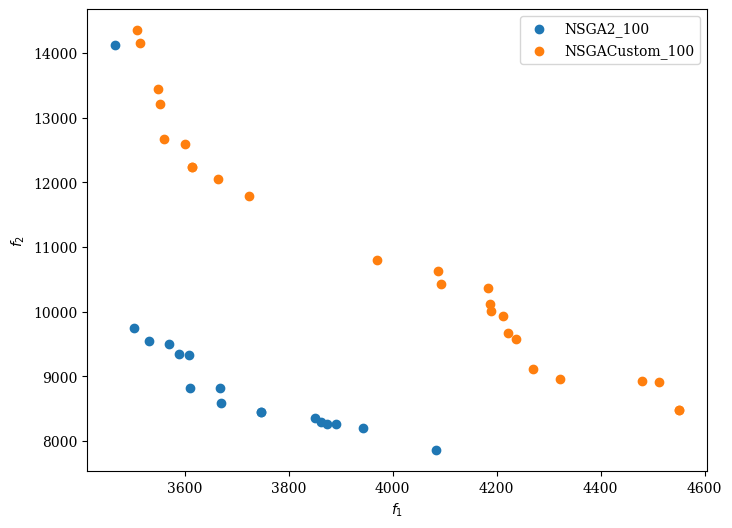

In [169]:
scatter = Scatter()
scatter.add(res_nsga2.F, label="NSGA2_100")
scatter.add(res_custom.F, label="NSGACustom_100")
scatter.legend=True
scatter.show()